In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train = pd.read_csv('Pre-processed Dataset/train.csv', encoding='latin-1', index_col=0)
test = pd.read_csv('Pre-processed Dataset/test.csv', encoding='latin-1', index_col=0)

In [ ]:
train['text'] = train['text'].values.astype(str)
test['text'] = test['text'].values.astype(str)

In [ ]:
# Tokenize words
from keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer()

In [ ]:
tokenizer.fit_on_texts(train.text)

In [ ]:
X_train = tokenizer.texts_to_sequences(train.text)
X_test  = tokenizer.texts_to_sequences(test.text)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
y_train_1 = train['senti'].values.astype(int)
y_test_1 = test['senti'].values.astype(int)

In [ ]:
# One-hot encoding the labels
from keras.utils import to_categorical
y_train = to_categorical(y_train_1)
y_test = to_categorical(y_test_1)

In [ ]:
# Pad sequences with zeros
from keras.preprocessing.sequence import pad_sequences

In [ ]:
X_train = pad_sequences(X_train, padding='post', maxlen=41)
X_test = pad_sequences(X_test, padding='post', maxlen=41)

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
embedding_dim = 50

In [ ]:
embedding_matrix = create_embedding_matrix('GloVe Embedding/glove.twitter.27B/glove.twitter.27B.50d.txt',tokenizer.word_index, embedding_dim)

In [ ]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.5197830787944316

In [ ]:
from keras.models import Sequential
from keras import layers

In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=41))
model.add(layers.Conv1D(200, 3, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3, activation='sigmoid'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 50)            2959600   
_________________________________________________________________
conv1d (Conv1D)              (None, 39, 200)           30200     
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                2010      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 2,991,843
Trainable params: 2,991,843
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=10, verbose=False, validation_data=(X_test, y_test), batch_size=10)

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9961
Testing Accuracy:  0.7678


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

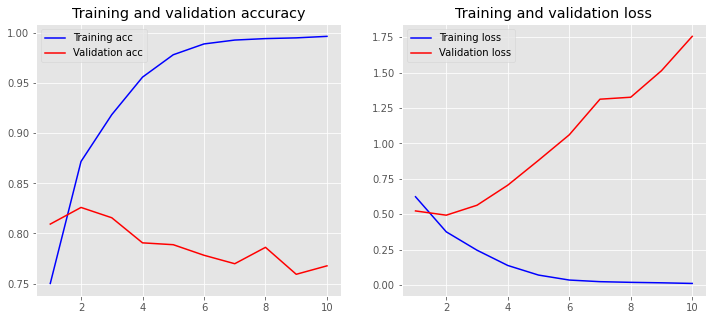

In [ ]:
plot_history(history)